<a href="https://colab.research.google.com/github/alexferrero23/twitter-category-nlp/blob/develop/src/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import glob
import re
import io

#### Select your file

In [2]:
from google.colab import files
uploaded = files.upload()

Saving working_df (1).orc to working_df (1).orc


In [3]:
import pyarrow.orc 

df = pd.read_orc('working_df (1).orc')

In [5]:
df.head(5)

,username,created_at,text,lang,label,retweet_count,favorite_count,length
0,RepAdams,2022-04-30 14:42:28,Today my thoughts are with the entire UNC Char...,en,D,3.0,17.0,263
1,RepAdams,2022-04-29 16:40:17,Welcome to the next President of DavidsonColle...,en,D,1.0,0.0,62
2,RepAdams,2022-04-29 01:52:24,"This WorkersMemorialDay, we remember countless...",en,D,2.0,3.0,262
3,RepAdams,2022-04-25 15:38:45,It’s a perfect date to celebrate the 40th Anni...,en,D,3.0,29.0,163
4,RepAdams,2022-04-22 19:57:41,Happy National Volunteer Week! Volunteers mak...,en,D,2.0,6.0,182


# DELETE THIS. ITS JUST FOR EFICIENCY TESTING MODELS

In [6]:
df_original = df

In [7]:
from sklearn.utils import shuffle
df_d = shuffle(df[df['label']=='D'][:10000])
df_r = shuffle(df[df['label']=='R'][:10000])
df = df_d.append(df_r, ignore_index=True)


# -----------------------------------------------------

#### Let's create a column with a list of words from tweets

In [20]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))
import string
list_of_rubish = ['&amp;', '-', '…', '’', '“', '—', '”', 'amp'] #stop_words.extend(("amp"))

def create_corpus_column(tweet):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    cleaned_corpus = []
    corpus = tokenizer.tokenize(tweet)
    for word in corpus:
        if (word not in stop) and (word not in list_of_rubish) and (word not in string.punctuation):
             cleaned_corpus.append(word)
    return cleaned_corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
df['text_corpus'] = df['text'].apply(create_corpus_column)

In [13]:
df.head(5)

,username,created_at,text,lang,label,retweet_count,favorite_count,length,text_corpus
0,RepColinAllred,2020-04-29 14:15:16,The 2020Census is critical to determining how ...,en,D,4.0,5.0,210,"[2020census, critical, determining, much, mone..."
1,RepColinAllred,2020-03-27 18:00:22,I spoke in the House today to North Texans doi...,en,D,14.0,108.0,276,"[spoke, house, today, north, texans, weather, ..."
2,RepCindyAxne,2021-10-16 16:49:09,💡Don't forget that entries for the 2021 Congre...,en,D,3.0,3.0,210,"[💡, forget, entries, 2021, congressional, app,..."
3,RepColinAllred,2022-02-08 00:52:34,Survivors of sexual assault deserve to have th...,en,D,26.0,86.0,273,"[survivors, sexual, assault, deserve, day, cou..."
4,SenAngusKing,2020-02-12 19:27:52,Coronavirus is a serious threat to global heal...,en,D,25.0,122.0,252,"[coronavirus, serious, threat, global, health,..."


#### First of all, I wanna check correlation between the two groups

In [14]:
# Unnest of text_corpus
df_tidy = df.explode(column='text_corpus')
df_tidy = df_tidy.drop(columns='text')
df_tidy.head(3)

,username,created_at,lang,label,retweet_count,favorite_count,length,text_corpus
0,RepColinAllred,2020-04-29 14:15:16,en,D,4.0,5.0,210,2020census
0,RepColinAllred,2020-04-29 14:15:16,en,D,4.0,5.0,210,critical
0,RepColinAllred,2020-04-29 14:15:16,en,D,4.0,5.0,210,determining


In [15]:
# Data pivot by label
df_pivot = df_tidy.groupby(["label","text_corpus"])["text_corpus"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "text_corpus" , columns="label", values= "count")
df_pivot.columns.name = None

In [16]:
# Consine similarity
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

df_pivot.corr(method=similitud_coseno)

,D,R
D,1.000000,0.812885
R,0.812885,1.000000


#### ***This is actually really bad news, if there is a big correlation between both groups, its gonna be really difficult to say whether a tweet tends to be republican or democrat***

---



#MODEL
#### For the feature extraction, I'm gonna use Tf-idf (Term frequency – Inverse document frequency) -> Weighing words by how frequent they are in our dataset, discounting words that are too frequent, as they just add to the noise
For model purposes, lets change label from letters to numbers: R -> 0 and D -> 1:


In [22]:
df['label_number'] = df['label'].apply(lambda x: 0 if x == 'R' else 1)

In [18]:
#train-test split
from sklearn.model_selection import train_test_split

datos_X = df.text
datos_y = df.label_number

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = 123
    
)

In [19]:
#check of proportions in both sets
value, counts = np.unique(y_train, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))
value, counts = np.unique(y_test, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))

{0: 49.90625, 1: 50.09375}
{0: 50.375, 1: 49.625}


In [20]:
#Tf-idf matrix
from sklearn.feature_extraction.text import TfidfVectorizer

def tokenize(tweet):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    corpus = tokenizer.tokenize(tweet)
    return corpus

vectorizer  = TfidfVectorizer(
                        tokenizer  = tokenize,
                        min_df     = 5 #might change
                    )
vectorizer.fit(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


TfidfVectorizer(min_df=5, tokenizer=<function tokenize at 0x7f7d97282cb0>)

In [21]:
tfidf_train = vectorizer.transform(X_train)
tfidf_test  = vectorizer.transform(X_test)

In [22]:
print(f"Number of tokens created: {len(vectorizer.get_feature_names_out())}");

Number of tokens created: 6325


#### Function to visualize the embeddings in 2 dimensions:

In [23]:
from sklearn.decomposition import TruncatedSVD
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=2, alpha=.8, c=test_labels, cmap=ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Republicans')
            green_patch = mpatches.Patch(color='blue', label='Democrats')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})

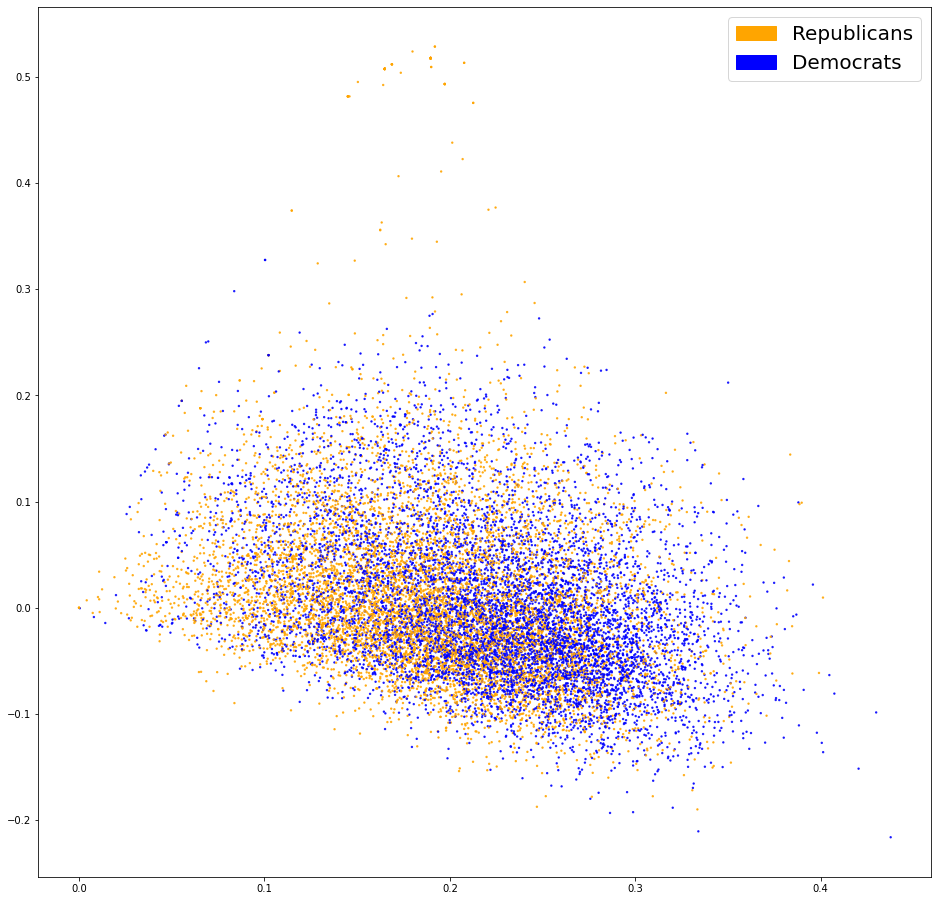

In [24]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(tfidf_train, y_train)
plt.show()

#### Considering the quantity of data we are using, let's say that these embeddings look more or less separated. Now, we check performance with a logistic regression:




In [25]:
%%time

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
log_reg.fit(tfidf_train, y_train)

y_hat = log_reg.predict(tfidf_test)

CPU times: user 44.9 ms, sys: 81.4 ms, total: 126 ms
Wall time: 2.55 s


#### Function to compute accuracy, precision, recall and f1 metrics

In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def get_metrics(y_test, y_hat): 
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_hat)

    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_hat, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_hat, pos_label=None,
                              average='weighted')
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_hat, pos_label=None, average='weighted')
    

    return accuracy, precision, recall, f1

In [27]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_hat)
print(f'accuracy = {accuracy_tfidf}, precision = {precision_tfidf}, recall = {recall_tfidf}, f1 = {f1_tfidf}')

accuracy = 0.88525, precision = 0.8852517073315871, recall = 0.88525, f1 = 0.8852481423254277


In [28]:
prop_1s = len(df[df['label_number']==1])/len(df)
print(f'Proportion of 1\'s in label_number in the dataset: {prop_1s}')

Proportion of 1's in label_number in the dataset: 0.5


#### In order to believe the value of the accuracy, per definition, it has to be bigger than the proportion of 1 in label_number in the dataset, which is correct

#### Confusion matrix

In [29]:
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(y_test, y_hat):
  
  conf_matrix = confusion_matrix(y_test, y_hat)
  plt.figure(figsize = (7,5))
  sns.heatmap(conf_matrix, annot=True, fmt='g');


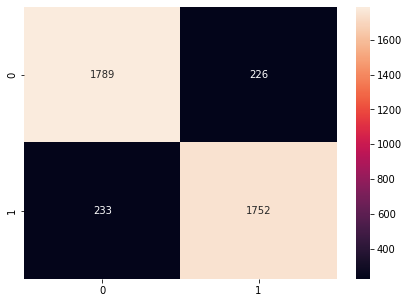

In [30]:
create_confusion_matrix(y_test, y_hat)

#### ROC Curve and area under the ROC Curve

In [58]:
from sklearn.metrics import roc_auc_score, roc_curve

def create_roc_curve(model, y_test, y_train):

  fig = plt.figure(figsize=(10, 10))          

  fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(tfidf_test)[:, 1])
  plt.plot(fpr, tpr, label="Test");

  fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(tfidf_train)[:, 1])
  plt.plot(fpr, tpr, label="Train");

  plt.legend(loc="lower right", prop={'size': 20});

  print(f'ROC AUC SCORE: {roc_auc_score(y_test, model.predict_proba(tfidf_test)[:, 1])}')


ROC AUC SCORE: 0.956688188710615


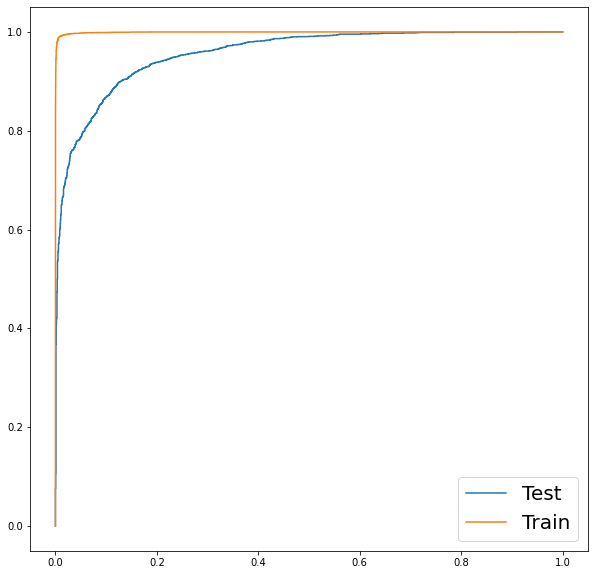

In [40]:
create_roc_curve(log_reg, y_test, y_train)

# PRETTY COOL, ADD CONCLUSIONS

These are really good results for a first try, but we don't know if they are the best. In order to discover that, I'm going to attemp a grid search for the logistic regression.

In [41]:
param_grid = [{'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'classifier__solver' : ['liblinear']},
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l2'],
    'classifier__C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'classifier__solver' : ['newton-cg', 'lbfgs']}]

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


pipe = Pipeline([('classifier' , LogisticRegression())])

grid = GridSearchCV(pipe, param_grid = param_grid, verbose=True, n_jobs=-1)

In [43]:
%%time

best_clf = grid.fit(tfidf_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: user 1.1 s, sys: 76.5 ms, total: 1.17 s
Wall time: 24.7 s


In [44]:
print('Best Score: %s' % best_clf.best_score_)
print('Best Hyperparameters: %s' % best_clf.best_params_)

Best Score: 0.8871874999999999
Best Hyperparameters: {'classifier': LogisticRegression(C=10, solver='liblinear'), 'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


In [45]:
best_model = best_clf.best_estimator_
y_hat = best_model.predict(tfidf_test)

In [46]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_hat)
print(f'accuracy = {accuracy_tfidf}, precision = {precision_tfidf}, recall = {recall_tfidf}, f1 = {f1_tfidf}')

accuracy = 0.889, precision = 0.8890646188700727, recall = 0.889, f1 = 0.8889887311307202


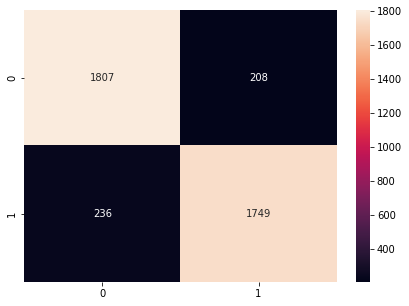

In [47]:
create_confusion_matrix(y_test, y_hat)

ROC AUC SCORE: 0.9612886974892338


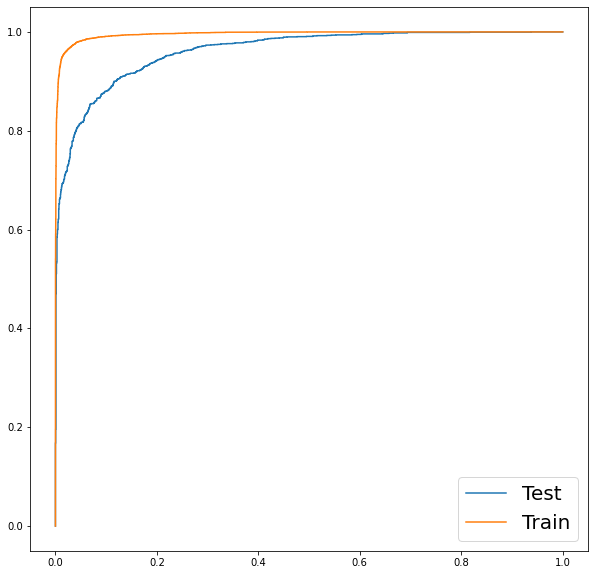

In [48]:
create_roc_curve(best_model, y_test, y_train)

#### Slightly better performance

#### Random forest are really slow

In [ ]:
#from sklearn.ensemble import RandomForestClassifier

#rf = RandomForestClassifier(oob_score=True)

In [ ]:
%%time

#rf.fit(tfidf_train, y_train)

#rf.oob_score_

In [ ]:
#y_hat = rf.predict(tfidf_test)
#probs = rf.predict_proba(tfidf_test)

In [ ]:
#get_metrics(y_test, y_hat)

### Gradient boosting: 
#### Grid search seems to be really slow, which is normal as it does a search evaluating all possible parameters. Maybe it would be better to do a random grid search

In [ ]:
#param_grid = {'n_estimators'  : [50, 100, 500, 1000],
#              'max_features'  : ['auto', 'sqrt', 'log2'],
#              'max_depth'     : [None, 1, 3, 5, 10, 20],
#              'subsample'     : [0.5, 1],
#              'learning_rate' : [0.001, 0.01, 0.1]
3
#             }

In [ ]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.model_selection import RepeatedKFold
#import multiprocessing

#grid = GridSearchCV(
#        estimator  = GradientBoostingClassifier(random_state=123),
#        param_grid = param_grid,
#        scoring    = 'accuracy',
#        n_jobs     = multiprocessing.cpu_count() - 1,
#        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
#        refit      = True,
#        verbose    = 0,
#        return_train_score = True
#       )

In [ ]:
#grid.fit(tfidf_train, y_train)

#1 hour and a half is enough to stop it tbh

In [ ]:
#resultados = pd.DataFrame(grid.cv_results_)

In [ ]:
#resultados

#### XGBoost

In [49]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False
        )

In [50]:
%%time

xgb_model.fit(tfidf_train, y_train)

CPU times: user 11.8 s, sys: 33 ms, total: 11.8 s
Wall time: 13 s


XGBClassifier(max_depth=7, n_estimators=80, use_label_encoder=False)

In [51]:
y_hat = xgb_model.predict(tfidf_test)

In [52]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_hat)
print(f'accuracy = {accuracy_tfidf}, precision = {precision_tfidf}, recall = {recall_tfidf}, f1 = {f1_tfidf}')

accuracy = 0.81525, precision = 0.8182053566371753, recall = 0.81525, f1 = 0.8147319669390252


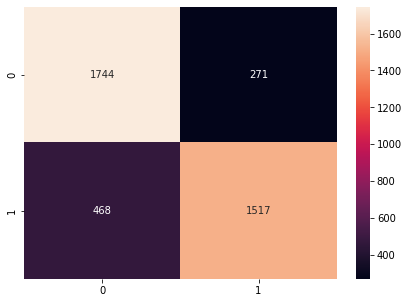

In [53]:
create_confusion_matrix(y_test, y_hat)

ROC AUC SCORE: 0.9086229850429087


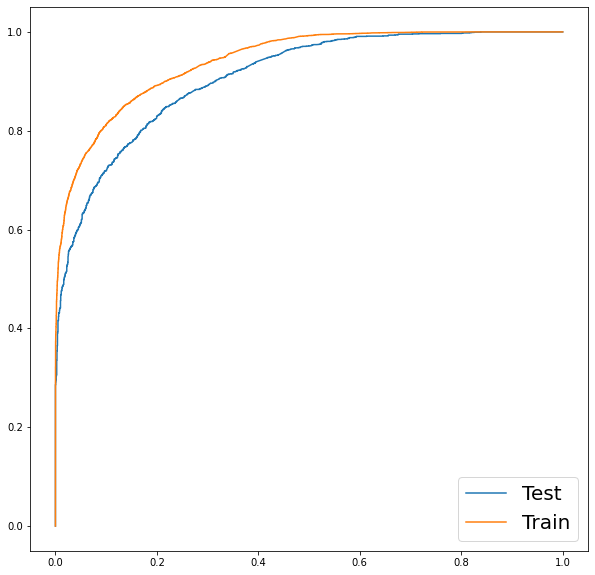

In [59]:
create_roc_curve(xgb_model, y_test, y_train)

#### A grid search for the XGBoost takes a lot of RAM, and cannot be executed in google colab with the free tier:

In [60]:
param_grid = {'xgb__max_depth'        : [None, 1, 3, 5, 10, 20],
              'xgb__subsample'        : [0.5, 1],
              'xgb__learning_rate'    : [0.001, 0.01, 0.1],
              'xgb__booster'          : ['gbtree']
             }

In [61]:
estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [62]:
parameters = {
    'max_depth': [None, 1, 3, 5, 10, 20],
    'n_estimators': [10,20,40,80],
    'learning_rate': [0.1, 0.01, 0.05]
}

In [63]:
grid_search_xgb = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [64]:
%%time

best_xgb = grid_search_xgb.fit(tfidf_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


KeyboardInterrupt: ignored

In [ ]:
print('Best Score: %s' % best_xgb.best_score_)
print('Best Hyperparameters: %s' % best_xgb.best_params_)

#### Let's try a Random Grid Search (PENDING)

---



In [ ]:
import time
for i in range(0,100000):
  time.sleep(100)
  print(i)

KeyboardInterrupt: ignored

In [ ]:
best_model_xgb = best_xgb.best_estimator_
y_hat = best_model_xgb.predict(tfidf_test)

In [ ]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_hat)
print(f'accuracy = {accuracy_tfidf}, precision = {precision_tfidf}, recall = {recall_tfidf}, f1 = {f1_tfidf}')

In [ ]:
create_confusion_matrix(y_test, y_hat)

In [ ]:
create_roc_curve(xgb_model, y_test, y_train)

ADD CONCLUSIONS WHAT A SHIT

#### BERT 

In [8]:
!# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

 sample_data  'working_df (1).orc'


In [ ]:
!pip install -q tf-models-official

In [101]:
df_train = df.sample(frac=0.8,random_state=200).reset_index()[['text','label_number']]
df_val = df.sample(frac=0.2,random_state=200).reset_index()[['text','label_number']]

In [93]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [103]:
from tensorflow.keras.preprocessing.text import Tokenizer

tok = Tokenizer(oov_token='<unk>')
tok.fit_on_texts(train_text)
tok.word_index['<pad>'] = 0
tok.index_word[0] = '<pad>'

train_text = df_train['text'].to_numpy()
train_seqs = tok.texts_to_sequences(train_text)
train_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

train_labels = df_train['label_number'].to_numpy().flatten()

val_text = df_val['text'].to_numpy()
val_seqs = tok.texts_to_sequences(val_text)
val_seqs = tf.keras.preprocessing.sequence.pad_sequences(val_seqs, padding='post')

val_labels = df_val['label_number'].to_numpy().flatten()

In [104]:
train_ds = tf.data.Dataset.from_tensor_slices((train_seqs, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_seqs, val_labels))

In [105]:
BATCH_SIZE = 32
train_ds_batch = train_ds.batch(BATCH_SIZE)
val_ds_batch = val_ds.batch(BATCH_SIZE)

In [106]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_batch = train_ds_batch.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_batch = val_ds_batch.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

vocab_size =len(tok.word_index) + 1
embedding_dim = 256

model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid') # also tried activation='softmax'
])

model.compile(optimizer='adam',
              loss='binary_crossentropy', # binary_crossentropy
              metrics=['accuracy'])

history = model.fit(
    train_ds_batch,
    epochs=1,
    validation_data=val_ds_batch, validation_steps=1, steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
)

KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


#### Okay, now I wanna try word2vec to see if I can improve the model

In [ ]:
#!python -m gensim.downloader --download word2vec-google-news-300

In [ ]:
#import gensim

# Load Google's pre-trained Word2Vec model.
#word2vec_path = "~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
#word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)